# Peer-graded Assignment: Segmenting and Clustering Neighborhoods in Toronto

## Introduction:

For this assignment, you will be required to explore and cluster the neighborhoods in Toronto.

## Data Preperation

Import packages and scrape the tabular geo data from the Wikipedia page given below 

In [39]:
#!pip install beautifulsoup4
#!pip install requests

import requests
from bs4 import BeautifulSoup
import pandas as pd
from pandas.io.json import json_normalize

response = requests.get(url="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M",)
print(response.status_code)
soup = BeautifulSoup(response.content, 'html.parser')
title = soup.find(id="firstHeading")
pretty_soup = soup.prettify()
print (soup.title.string)

all_tables=soup.find_all('table')
# get right table to scrap
right_table=soup.find('table', {"class":'wikitable sortable'})
# number of columns in the table
for row in right_table.findAll("tr"):
    cells = row.findAll('td')
print ("number of columns:",len(cells))
# number of rows in the table including header
rows = right_table.findAll("tr")
print ("number of rows including title:",len(rows))
# header attributes of the table
header = [th.text.rstrip() for th in rows[0].find_all('th')]
print("hearders:", header, "number of headers:",len(header))


200
List of postal codes of Canada: M - Wikipedia
number of columns: 3
number of rows including title: 181
hearders: ['Postal Code', 'Borough', 'Neighbourhood'] number of headers: 3


In [2]:
# Get tabular data (a list of lists)
lst_data = []
for row in rows[1:]:
            data = [d.text.rstrip() for d in row.find_all('td')] # select also works as find_all
            lst_data.append(data)


# Change it to DataFrame
df = pd.DataFrame.from_records(lst_data, columns = header)
df

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...
175,M5Z,Not assigned,Not assigned
176,M6Z,Not assigned,Not assigned
177,M7Z,Not assigned,Not assigned
178,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."


In [3]:
# Drop rows with not assigned values in Borough column
# And combined rows which have the same postal codes

df2 = df.groupby(['Postal Code', 'Borough'])['Neighbourhood'].apply(', '.join).reset_index()
df2.drop(df2[(df2.Borough == 'Not assigned')].index, inplace=True)

# If neighbourhood is 'Not assignmend', then let it be the same as borough
for n in df2.index:
    if df2.at[n,'Neighbourhood'] == 'Not assigned':
        df2.at[n,'Neighbourhood'] = df2.at[n,'Borough'] 
df2.head()

,Postal Code,Borough,Neighbourhood
1,M1B,Scarborough,"Malvern, Rouge"
2,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
3,M1E,Scarborough,"Guildwood, Morningside, West Hill"
4,M1G,Scarborough,Woburn
5,M1H,Scarborough,Cedarbrae


In [4]:
df2.shape

(103, 3)

## Graphical Data for Toronto

Get the latitude and longitude for each postal code.  
Here we use the given csv file which contains corresponding axis for each post code,
since the geocoder package is quite unstable

In [7]:
#!pip3 install geocoder
#import geocoder


#def get_geocoder(postal_code):
#    lis = []
#    lat_lng_coords = None
#    while(lat_lng_coords is None):
#        g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
#        lat_lng_coords = g.latlng

#    latitude = lat_lng_coords[0]
#    longitude = lat_lng_coords[1]
#    lis.append(atitude)
#    lis.append(longitude)
#    return lis

##df2['Latitude'], df2['Longitude'] = zip(*df2['Postal Code'].apply(get_geocoder))
#for i in range(1,len(df2['Postal Code'])):
#    lis2 = get_geocoder(df2.at[i,'Postal Code'])
#    df2.at[i,'Latitude'] = lis2[0]
#    df2.at[i,'Longitude'] = lis2[1]


url = "https://cocl.us/Geospatial_data"
geoData =pd.read_csv(url)

geo_df = pd.merge(df2, geoData, on='Postal Code')
geo_df

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437


### Create a map of Toronto with neighborhoods

In [13]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!pip3 install folium # uncomment this line if you haven't completed the Foursquare API lab
import folium 
from geopy.geocoders import Nominatim

Use geopy library to get the latitude and longitude values of Toronto.

In [26]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="trt_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [32]:
# create map of Toronto using latitude and longitude values
map_trt = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(geo_df['Latitude'], geo_df['Longitude'], geo_df['Borough'], geo_df['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_trt)  
    
map_trt

## Foursquare API Usage

In [143]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20210114' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


In [144]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

In [142]:
results = requests.get(url).json()

In [40]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#pull the actual data from the Foursquare API

venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
filtered_columns = ['venue.name', 'venue.id', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues

#column formatting
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:15: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,name,id,categories,lat,lng
0,Downtown Toronto,5227bb01498e17bf485e6202,Neighborhood,43.653232,-79.385296
1,Nathan Phillips Square,4ad4c05ef964a520a6f620e3,Plaza,43.652270,-79.383516
2,Japango,4ae7b27df964a52068ad21e3,Sushi Restaurant,43.655268,-79.385165
3,Poke Guys,57bcd3b7498e652a678d0378,Poke Place,43.654895,-79.385052
4,Indigo,4b2a6eb8f964a52012a924e3,Bookstore,43.653515,-79.380696
...,...,...,...,...,...
68,Jack Astor's Bar & Grill,4ad9ffbbf964a520091d21e3,Restaurant,43.656019,-79.380326
69,Pantages Hotel & Spa,4ae61cf6f964a520caa421e3,Hotel,43.654498,-79.379035
70,Tim Hortons,4b7aa994f964a5200c362fe3,Coffee Shop,43.655212,-79.380063
71,Pantages Lounge & Bar,4b6a0069f964a520f3c02be3,Cocktail Bar,43.654493,-79.379000


In [41]:
# find a list of unique categories from the API so we can see what may or may not fit for restaurants

nearby_venues['categories'].unique()

array(['Neighborhood', 'Plaza', 'Sushi Restaurant', 'Poke Place',
       'Bookstore', 'Bubble Tea Shop', 'Art Museum', 'Shopping Mall',
       'Monument / Landmark', 'Cosmetics Shop', 'Coffee Shop', 'Hotel',
       'Fast Food Restaurant', 'Concert Hall', 'Miscellaneous Shop',
       'Clothing Store', 'Theater', 'Seafood Restaurant',
       'American Restaurant', 'Vegetarian / Vegan Restaurant',
       'Department Store', 'Electronics Store', 'Tanning Salon',
       'Restaurant', 'Food Court', 'Gastropub', 'Opera House',
       'Comic Shop', 'Pizza Place', 'Modern European Restaurant',
       'Furniture / Home Store', 'Steakhouse',
       'Latin American Restaurant', 'Bank', 'Gym / Fitness Center',
       'Music Venue', 'Burger Joint', 'Café', 'New American Restaurant',
       'Jazz Club', 'Smoothie Shop', 'Mexican Restaurant', 'Diner',
       'Breakfast Spot', 'Office', 'Colombian Restaurant',
       'Video Game Store', 'Middle Eastern Restaurant', 'Movie Theater',
       'Shoe Store',

In [42]:
# creating a list of categorie to remove from our dataframe because they are not restaurants
# I am sure there is a function that can be written to do this at scale but since it was a small list, I did it manually

removal_list = ['Gym / Fitness Center', 'Bakery', 'Park', "Women's Store", 'Sporting Goods Shop', 'Dog Run', 'Gaming Cafe',
               'Optical Shop', 'Yoga Studio', 'Pet Store', 'Shoe Repair', 'Jewelry Store', 'Record Shop', 'Juice Bar', 
               'Cosmetics Shop', 'Business Service', 'Salon / Barbershop', 'Liquor Store', 'Grocery Store', 'Stationery Store',
               'Pilates Studio', 'Dessert Shop', 'Bookstore', 'Concert Hall', 'Video Game Store', 'Pharmacy', 'Mobile Phone Shop',
               'Deli / Bodega']

nearby_venues2 = nearby_venues.copy()


#getting a clear dataframe of just restaurants
nearby_venues2 = nearby_venues2[~nearby_venues2['categories'].isin(removal_list)]
nearby_venues2

,name,id,categories,lat,lng
0,Downtown Toronto,5227bb01498e17bf485e6202,Neighborhood,43.653232,-79.385296
1,Nathan Phillips Square,4ad4c05ef964a520a6f620e3,Plaza,43.652270,-79.383516
2,Japango,4ae7b27df964a52068ad21e3,Sushi Restaurant,43.655268,-79.385165
3,Poke Guys,57bcd3b7498e652a678d0378,Poke Place,43.654895,-79.385052
5,Chatime 日出茶太,4e2284b11fc7c0ef9857d143,Bubble Tea Shop,43.655542,-79.384684
...,...,...,...,...,...
68,Jack Astor's Bar & Grill,4ad9ffbbf964a520091d21e3,Restaurant,43.656019,-79.380326
69,Pantages Hotel & Spa,4ae61cf6f964a520caa421e3,Hotel,43.654498,-79.379035
70,Tim Hortons,4b7aa994f964a5200c362fe3,Coffee Shop,43.655212,-79.380063
71,Pantages Lounge & Bar,4b6a0069f964a520f3c02be3,Cocktail Bar,43.654493,-79.379000


In [141]:
#let's get a list of venues

venue_id_list = nearby_venues2['id'].tolist()

In [45]:
#set up to pull the likes from the API based on venue ID

url_list = []
like_list = []
json_list = []

for i in venue_id_list:
    venue_url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET, VERSION)
    url_list.append(venue_url)
for link in url_list:
    result = requests.get(link).json()
    likes = result['response']['likes']['count']
    like_list.append(likes)
print(like_list)

#double check that we did not lose any venues based on if likes were available

print(len(like_list))
print(len(venue_id_list))

[316, 692, 161, 32, 198, 25, 2986, 73, 32, 84, 8, 135, 114, 198, 9, 21, 248, 29, 164, 573, 493, 823, 5, 269, 67, 232, 21, 30, 115, 76, 6, 28, 40, 43, 73, 29, 24, 230, 8, 19, 141, 44, 204, 204, 5, 8, 171, 22, 181, 75, 85, 45, 25, 10, 199, 7, 13, 133, 417, 7, 5, 28, 263, 27, 0, 5, 2]
67
67


## Data Preperation for Clustering

In [46]:
# Make a copy of our initial dataframe just in case anything goes wrong

to_venues = nearby_venues2.copy()
to_venues.head()

,name,id,categories,lat,lng
0,Downtown Toronto,5227bb01498e17bf485e6202,Neighborhood,43.653232,-79.385296
1,Nathan Phillips Square,4ad4c05ef964a520a6f620e3,Plaza,43.652270,-79.383516
2,Japango,4ae7b27df964a52068ad21e3,Sushi Restaurant,43.655268,-79.385165
3,Poke Guys,57bcd3b7498e652a678d0378,Poke Place,43.654895,-79.385052
5,Chatime 日出茶太,4e2284b11fc7c0ef9857d143,Bubble Tea Shop,43.655542,-79.384684


In [59]:
# add in the list of likes

to_venues['total likes'] = like_list

print(to_venues['total likes'].describe())
to_venues.head()

count      67.000000
mean      165.000000
std       386.530214
min         0.000000
25%        21.000000
50%        45.000000
75%       189.500000
max      2986.000000
Name: total likes, dtype: float64


,name,id,categories,lat,lng,total likes
0,Downtown Toronto,5227bb01498e17bf485e6202,Neighborhood,43.653232,-79.385296,316
1,Nathan Phillips Square,4ad4c05ef964a520a6f620e3,Plaza,43.652270,-79.383516,692
2,Japango,4ae7b27df964a52068ad21e3,Sushi Restaurant,43.655268,-79.385165,161
3,Poke Guys,57bcd3b7498e652a678d0378,Poke Place,43.654895,-79.385052,32
5,Chatime 日出茶太,4e2284b11fc7c0ef9857d143,Bubble Tea Shop,43.655542,-79.384684,198


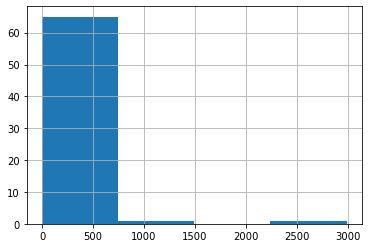

21.0
45.0
189.5


In [62]:
# Visualize the total likes based on a histogram

import matplotlib.pyplot as plt
import numpy as np
to_venues['total likes'].hist(bins=4)
plt.show()

# Use percentile to find the categories for total likes

print(np.percentile(to_venues['total likes'], 25))
print(np.percentile(to_venues['total likes'], 50))
print(np.percentile(to_venues['total likes'], 75))

In [131]:
# now we have our bin values so let's set them to the appropriate values
# less than 21, 21-45, 45-189, 189>
# poor, below avg, abv avg, great

poor = to_venues['total likes']<=21
below_avg = to_venues[(to_venues['total likes']>21) & (to_venues['total likes']<=45)]
abv_avg = to_venues[(to_venues['total likes']>45) & (to_venues['total likes']<=189)]
great = to_venues['total likes']>189

# Set up a function that will re-categorize our restaurants based on likes

def conditions(s):
    if s['total likes']<=21:
        return 'poor'
    if s['total likes']<=45:
        return 'below avg'
    if s['total likes']<=189:
        return 'avg avg'
    if s['total likes']>189:
        return 'great'

to_venues['total likes_cat']=to_venues.apply(conditions, axis=1)
to_venues

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
0,Downtown Toronto,5227bb01498e17bf485e6202,Neighborhood,43.653232,-79.385296,316,great,other,1
1,Nathan Phillips Square,4ad4c05ef964a520a6f620e3,Plaza,43.652270,-79.383516,692,great,other,1
2,Japango,4ae7b27df964a52068ad21e3,Sushi Restaurant,43.655268,-79.385165,161,avg avg,asia indian food,0
3,Poke Guys,57bcd3b7498e652a678d0378,Poke Place,43.654895,-79.385052,32,below avg,asia indian food,2
5,Chatime 日出茶太,4e2284b11fc7c0ef9857d143,Bubble Tea Shop,43.655542,-79.384684,198,great,sweet and beverage,1
...,...,...,...,...,...,...,...,...,...
68,Jack Astor's Bar & Grill,4ad9ffbbf964a520091d21e3,Restaurant,43.656019,-79.380326,263,great,american food,1
69,Pantages Hotel & Spa,4ae61cf6f964a520caa421e3,Hotel,43.654498,-79.379035,27,below avg,other,2
70,Tim Hortons,4b7aa994f964a5200c362fe3,Coffee Shop,43.655212,-79.380063,0,poor,sweet and beverage,3
71,Pantages Lounge & Bar,4b6a0069f964a520f3c02be3,Cocktail Bar,43.654493,-79.379000,5,poor,bars,3


In [132]:
# let's star the process for re-categorizing the categories

to_venues['categories'].unique()

array(['Neighborhood', 'Plaza', 'Sushi Restaurant', 'Poke Place',
       'Bubble Tea Shop', 'Art Museum', 'Shopping Mall',
       'Monument / Landmark', 'Coffee Shop', 'Hotel',
       'Fast Food Restaurant', 'Miscellaneous Shop', 'Clothing Store',
       'Theater', 'Seafood Restaurant', 'American Restaurant',
       'Vegetarian / Vegan Restaurant', 'Department Store',
       'Electronics Store', 'Tanning Salon', 'Restaurant', 'Food Court',
       'Gastropub', 'Opera House', 'Comic Shop', 'Pizza Place',
       'Modern European Restaurant', 'Furniture / Home Store',
       'Steakhouse', 'Latin American Restaurant', 'Bank', 'Music Venue',
       'Burger Joint', 'Café', 'New American Restaurant', 'Jazz Club',
       'Smoothie Shop', 'Mexican Restaurant', 'Diner', 'Breakfast Spot',
       'Office', 'Colombian Restaurant', 'Middle Eastern Restaurant',
       'Movie Theater', 'Shoe Store', 'Noodle House', 'Salad Place',
       'Thai Restaurant', 'Vietnamese Restaurant', 'Cocktail Bar'],
     

In [133]:
# Create new categories to summarize th data and to reduce the number of existing categories


bars = ['Pub', 'Cocktail Bar', 'Bar', 'Dive Bar', 'Sports Bar', 'Jazz Club', 'Gastropub']
other = ['Neighborhood', 'Art Museum', 'Shopping Mall', 'Hotel', 'Opera House', 'Bank', 'Music Venue', 'Movie Theater', 'Plaza', 'Monument / Landmark', 'Theater']
stores = ['Miscellaneous Shop', 'Clothing Store', 'Furniture / Home Store', 'Shoe Store', 'Tanning Salon', 'Electronics Store', 'Department Store', 'Comic Shop']
sweets_beverage = [ 'Tea Room', 'Donut Shop', 'Coffee Shop', 'Bubble Tea Shop', 'Boutique', 'Ice Cream Shop', 'Café', 'Smoothie Shop']
asia_indian_food = ['Middle Eastern Restaurant',  'Falafel Restaurant', 'Korean Restaurant','Sushi Restaurant', 'Indian Restaurant', 'Japanese Restaurant', 'Poke Place', 'Thai Restaurant', 'Vietnamese Restaurant', 'Noodle House']
mex_southam_food = ['Cuban Restaurant', 'Mexican Restaurant', 'South American Restaurant', 'Latin American Restaurant']
american_food = ['Latin American Restaurant', 'Restaurant', 'American Restaurant', 'New American Restaurant', 'Steakhouse','Restaurant', 'Diner']
euro_italian_food = ['Modern European Restaurant','Italian Restaurant', 'Seafood Restaurant']
fast_food = ['Food Court', 'Pizza Place', 'Burger Joint', 'Fast Food Restaurant']
breakfast = ['Bagel Shop', 'Sandwich Place', 'Breakfast Spot']
vegan = ['Vegetarian / Vegan Restaurant', 'Salad Place']



def conditions2(s):
    if s['categories'] in bars:
        return 'bars'
    if s['categories'] in sweets_beverage:
        return 'sweet and beverage'
    if s['categories'] in other:
        return 'other'
    if s['categories'] in stores:
        return 'stores'
    if s['categories'] in asia_indian_food:
        return 'asia indian food'
    if s['categories'] in mex_southam_food:
        return 'mex southam food'
    if s['categories'] in american_food:
        return 'american food'
    if s['categories'] in euro_italian_food:
        return 'euro italian food'
    if s['categories'] in fast_food:
        return 'fast food'
    if s['categories'] in breakfast:
        return 'breakfast'
    if s['categories'] in vegan:
        return 'vegan'
    

to_venues['categories_new']=to_venues.apply(conditions2, axis=1)
to_venues

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
0,Downtown Toronto,5227bb01498e17bf485e6202,Neighborhood,43.653232,-79.385296,316,great,other,1
1,Nathan Phillips Square,4ad4c05ef964a520a6f620e3,Plaza,43.652270,-79.383516,692,great,other,1
2,Japango,4ae7b27df964a52068ad21e3,Sushi Restaurant,43.655268,-79.385165,161,avg avg,asia indian food,0
3,Poke Guys,57bcd3b7498e652a678d0378,Poke Place,43.654895,-79.385052,32,below avg,asia indian food,2
5,Chatime 日出茶太,4e2284b11fc7c0ef9857d143,Bubble Tea Shop,43.655542,-79.384684,198,great,sweet and beverage,1
...,...,...,...,...,...,...,...,...,...
68,Jack Astor's Bar & Grill,4ad9ffbbf964a520091d21e3,Restaurant,43.656019,-79.380326,263,great,american food,1
69,Pantages Hotel & Spa,4ae61cf6f964a520caa421e3,Hotel,43.654498,-79.379035,27,below avg,other,2
70,Tim Hortons,4b7aa994f964a5200c362fe3,Coffee Shop,43.655212,-79.380063,0,poor,sweet and beverage,3
71,Pantages Lounge & Bar,4b6a0069f964a520f3c02be3,Cocktail Bar,43.654493,-79.379000,5,poor,bars,3


In [134]:
# one hot encoding
to_onehot = pd.get_dummies(to_venues[['categories_new', 'total likes_cat']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Name'] = to_venues['name'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

to_onehot.head()

,Name,american food,asia indian food,bars,breakfast,euro italian food,fast food,mex southam food,other,stores,sweet and beverage,vegan,avg avg,below avg,great,poor
0,Downtown Toronto,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,Nathan Phillips Square,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,Japango,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,Poke Guys,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
5,Chatime 日出茶太,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [135]:
cluster_df = to_onehot.drop('Name', axis=1)

k_clusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(cluster_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 1, 0, 2, 1, 2, 1, 0, 2, 0, 3, 0, 0, 1, 3, 3, 1, 2, 0, 1, 1, 1,
       3, 1, 0, 1, 3, 2, 0, 0, 3, 2, 2, 2, 0, 2, 2, 1, 3, 3, 0, 2, 1, 1,
       3, 3, 0, 2, 0, 0, 0, 2, 2, 3, 1, 3, 3, 0, 1, 3, 3, 2, 1, 2, 3, 3,
       3], dtype=int32)

In [136]:
to_venues['label'] = kmeans.labels_
to_venues.head()

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
0,Downtown Toronto,5227bb01498e17bf485e6202,Neighborhood,43.653232,-79.385296,316,great,other,1
1,Nathan Phillips Square,4ad4c05ef964a520a6f620e3,Plaza,43.652270,-79.383516,692,great,other,1
2,Japango,4ae7b27df964a52068ad21e3,Sushi Restaurant,43.655268,-79.385165,161,avg avg,asia indian food,0
3,Poke Guys,57bcd3b7498e652a678d0378,Poke Place,43.654895,-79.385052,32,below avg,asia indian food,2
5,Chatime 日出茶太,4e2284b11fc7c0ef9857d143,Bubble Tea Shop,43.655542,-79.384684,198,great,sweet and beverage,1


In [137]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=15)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i+x+(i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_venues['lat'], to_venues['lng'], to_venues['name'], to_venues['label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [138]:
to_venues.loc[to_venues['label']==0]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
2,Japango,4ae7b27df964a52068ad21e3,Sushi Restaurant,43.655268,-79.385165,161,avg avg,asia indian food,0
8,Old City Hall,4ad4c05ef964a5208ef620e3,Monument / Landmark,43.652009,-79.381744,73,avg avg,other,0
11,Marriott Downtown at CF Toronto Eaton Centre,4b0563c0f964a5200e5822e3,Hotel,43.654728,-79.382422,84,avg avg,other,0
14,MUJI,5479da4f498e8569fb44985c,Miscellaneous Shop,43.656024,-79.383284,135,avg avg,stores,0
15,UNIQLO ユニクロ,57eda381498ebe0e6ef40972,Clothing Store,43.655910,-79.380641,114,avg avg,stores,0
22,Elgin And Winter Garden Theatres,4ad4c062f964a520b5f720e3,Theater,43.653394,-79.378507,164,avg avg,other,0
28,Assembly Chef's Hall,5a32970da42362290203a9d6,Food Court,43.650579,-79.383412,67,avg avg,fast food,0
32,Silver Snail Comics,4ad4c062f964a5200bf820e3,Comic Shop,43.657031,-79.381403,115,avg avg,stores,0
33,Blaze Pizza,5615b6c4498e3c32c67ad78f,Pizza Place,43.656518,-79.380015,76,avg avg,fast food,0
38,Leña,57d0a3fb498e0fb29e892eed,Latin American Restaurant,43.651722,-79.379205,73,avg avg,mex southam food,0


In [139]:
to_venues.loc[to_venues['label']==1]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
0,Downtown Toronto,5227bb01498e17bf485e6202,Neighborhood,43.653232,-79.385296,316,great,other,1
1,Nathan Phillips Square,4ad4c05ef964a520a6f620e3,Plaza,43.652270,-79.383516,692,great,other,1
5,Chatime 日出茶太,4e2284b11fc7c0ef9857d143,Bubble Tea Shop,43.655542,-79.384684,198,great,sweet and beverage,1
7,CF Toronto Eaton Centre,4ad77a12f964a520260b21e3,Shopping Mall,43.654447,-79.380952,2986,great,other,1
16,Ed Mirvish Theatre,4ad4c062f964a520c5f720e3,Theater,43.655102,-79.379768,198,great,other,1
19,Richmond Station,506db1a9e4b0a3f3b31412f0,American Restaurant,43.651569,-79.379266,248,great,american food,1
23,Hudson's Bay,4adf85e1f964a5206e7b21e3,Department Store,43.652040,-79.380391,573,great,stores,1
24,Apple Eaton Centre,4ad788c8f964a520e40b21e3,Electronics Store,43.652818,-79.380617,493,great,stores,1
25,Yonge-Dundas Square,4ad8cd16f964a520c91421e3,Plaza,43.656054,-79.380495,823,great,other,1
27,The Keg Steakhouse + Bar - York Street,4ad69511f964a520e40721e3,Restaurant,43.649987,-79.384103,269,great,american food,1


In [140]:
to_venues.loc[to_venues['label']==2]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
3,Poke Guys,57bcd3b7498e652a678d0378,Poke Place,43.654895,-79.385052,32,below avg,asia indian food,2
6,Textile Museum of Canada,4ad4c05ef964a520e2f620e3,Art Museum,43.654396,-79.386500,25,below avg,other,2
10,M Square Coffee Co,54132b3b498ee9ca9332e189,Coffee Shop,43.651218,-79.383555,32,below avg,sweet and beverage,2
20,Rosalinda,5aff06ca6e4650002cc6286b,Vegetarian / Vegan Restaurant,43.650252,-79.385156,29,below avg,vegan,2
31,Roots,4b40f62ef964a52050be25e3,Clothing Store,43.653613,-79.380244,30,below avg,stores,2
35,The Elm Tree Restaurant,539c6f13498e06f4cc765165,Modern European Restaurant,43.657397,-79.383761,28,below avg,euro italian food,2
36,HomeSense,4af72034f964a5202b0622e3,Furniture / Home Store,43.653053,-79.379450,40,below avg,stores,2
37,Hy's Steakhouse,4bd8cde92e6f0f47dcb20808,Steakhouse,43.649505,-79.382919,43,below avg,american food,2
39,Tangerine Café,4dc16c718877c00d6ad7f2a6,Bank,43.653937,-79.379722,29,below avg,other,2
41,Jazz Bistro,514cc159e4b0e4f73af4eced,Music Venue,43.655678,-79.379276,24,below avg,other,2


In [130]:
to_venues.loc[to_venues['label']==3]

,name,id,categories,lat,lng,total likes,total likes_cat,categories_new,label
12,Crepe Delicious,4e5d8181a8092f63968617ee,Fast Food Restaurant,43.654536,-79.380889,8,poor,fast food,3
17,Bulldog On The Block,5a3a846af62e0960e9364d11,Coffee Shop,43.650652,-79.384141,9,poor,sweet and beverage,3
18,John & Sons Oyster House,50ecb1fae4b0beb13294f0aa,Seafood Restaurant,43.650656,-79.381613,21,poor,euro italian food,3
26,Solei Tanning Salon,4ba5208ff964a520f5e038e3,Tanning Salon,43.654734,-79.380248,5,poor,stores,3
30,Canadian Opera Company,4ad4c062f964a520baf720e3,Opera House,43.650660,-79.386242,21,poor,other,3
34,Magic Tailor,4afc79c8f964a520182322e3,Clothing Store,43.653742,-79.379745,6,poor,stores,3
43,Ted Baker,54516134498e019be8e568fc,Clothing Store,43.652843,-79.380325,8,poor,stores,3
44,Cafe Plenty,4f513029e4b07c3382c9fdb9,Café,43.654571,-79.389450,19,poor,sweet and beverage,3
49,Tokyo Smoke,5a55078bda5ede6ed9d73a62,Coffee Shop,43.657230,-79.380870,5,poor,sweet and beverage,3
50,Booster Juice,4b8eaea1f964a520b03033e3,Smoothie Shop,43.652658,-79.378459,8,poor,sweet and beverage,3


We can see that when lable = 1, the samples have the best performance;  
and when the lable = 3, most of the samples have 'poor' likes.